In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras
import os

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import random
from tensorflow.keras.preprocessing.image import load_img

In [2]:
IMAGE_SIZE = [224, 224]
weight_size = 224
height_size = 224
batch_size = 32

In [3]:
train_path = './data/train/'
valid_path = './data/valid/'
test_path = './data/test/'

### Data Exploration

In [4]:
# Get a list of classes (groups) in your dataset
classes = [class_name for class_name in sorted(os.listdir(train_path)) if not class_name.startswith('.')]
print("Classes:", classes)

Classes: ['kick', 'kicknt', 'punch', 'punchnt']


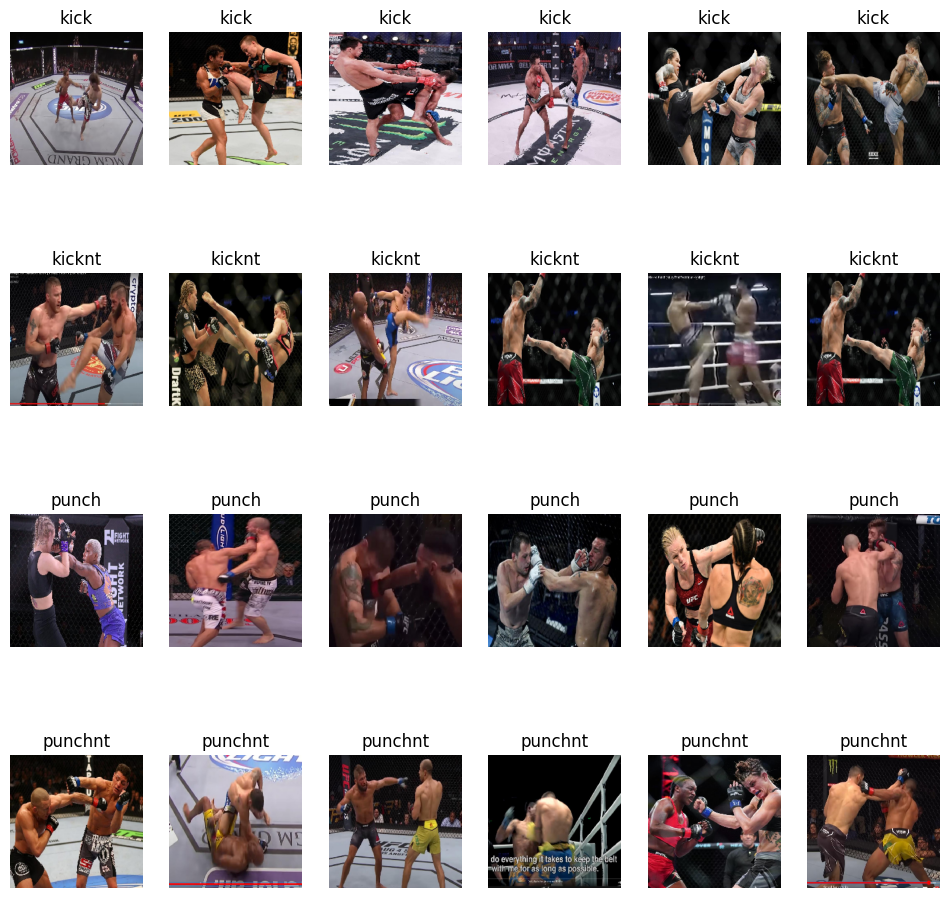

In [5]:
# Number of samples per class to display
num_samples_per_class = 6

# Function to display sample images from each class
def show_sample_images(data_dir, classes, num_samples_per_class):
    plt.figure(figsize=(12,12))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_images = random.sample(os.listdir(class_dir), num_samples_per_class)

        for j, image_name in enumerate(class_images):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(weight_size, height_size))

            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Call the function to show sample images from each class
show_sample_images(train_path, classes, num_samples_per_class)


In [6]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
for layer in vgg.layers:
    layer.trainable = False

In [8]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
folders = glob('data/train/*')

In [36]:
len(folders)

4

In [55]:
x = Flatten()(vgg.output)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

In [56]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [57]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0,1]
    rotation_range=90,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.4,       # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.4,      # Randomly shift images vertically by up to 20% of the height
    shear_range=0.5,             # Apply shear transformation
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Use the nearest pixel to fill missing areas after augmentation
)

In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [59]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [60]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 409 images belonging to 4 classes.


In [61]:
test_set = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 60 images belonging to 4 classes.


In [62]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 128 images belonging to 4 classes.


### Displaying the augmentation of the images

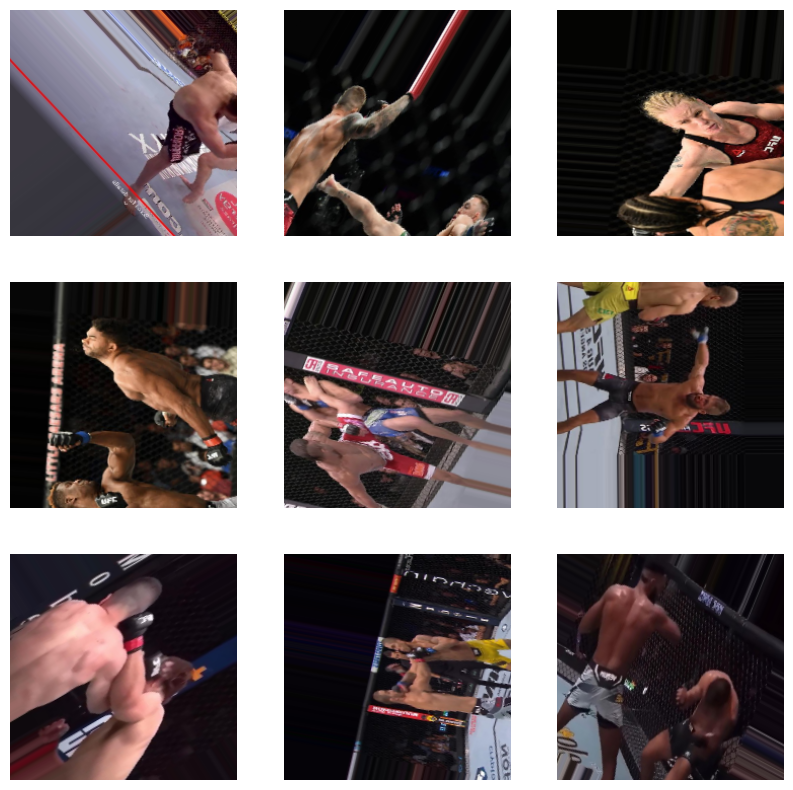

In [63]:
plt.figure(figsize=(10, 10))
images, _ = next(training_set)
for i, image in enumerate(images[: 9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

In [78]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [79]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_with_vgg.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_set,
    epochs=100,
    validation_data=valid_set,
    callbacks=callbacks)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_60388/3977881107.py", line 7, in <module>
      history = model.fit(
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/home/jorgeluisg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,4] and labels shape [128]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_55883]

In [66]:
test_model = keras.models.load_model(
    "./models/convnet_with_vgg.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2/2 [==============================] - 0s 99ms/step - loss: 1.3779 - accuracy: 0.3167
Test accuracy: 0.317


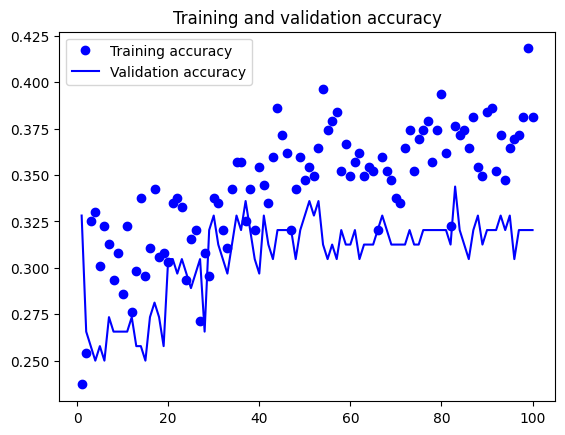

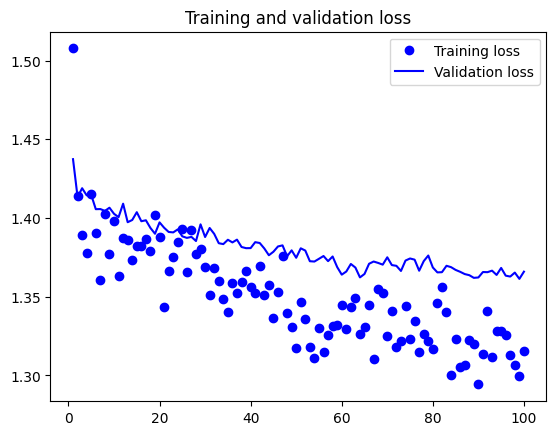

In [67]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Resnet50

In [68]:
from keras.applications.resnet_v2 import ResNet50V2

In [69]:
resnet = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [70]:
for layer in resnet.layers:
    layer.trainable = False

In [71]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [72]:
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)

In [73]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [74]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [75]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_with_resnet.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit_generator(
    training_set,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks)

/tmp/ipykernel_60388/161406448.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
13/13 [==============================] - 7s 329ms/step - loss: 16.0134 - accuracy: 0.2445 - val_loss: 18.6781 - val_accuracy: 0.3438
Epoch 2/50
13/13 [==============================] - 3s 267ms/step - loss: 11.2515 - accuracy: 0.3423 - val_loss: 6.9221 - val_accuracy: 0.4062
Epoch 3/50
13/13 [==============================] - 3s 241ms/step - loss: 9.3128 - accuracy: 0.3594 - val_loss: 7.6221 - val_accuracy: 0.3281
Epoch 4/50
13/13 [==============================] - 3s 242ms/step - loss: 9.7015 - accuracy: 0.3399 - val_loss: 10.7884 - val_accuracy: 0.2578
Epoch 5/50
13/13 [==============================] - 3s 244ms/step - loss: 9.9217 - accuracy: 0.3961 - val_loss: 9.6228 - val_accuracy: 0.3047
Epoch 6/50
13/13 [==============================] - 3s 256ms/step - loss: 10.4202 - accuracy: 0.3741 - val_loss: 10.5736 - val_accuracy: 0.3516
Epoch 7/50
13/13 [==============================] - 3s 262ms/step - loss: 9.8480 - accuracy: 0.4059 - val_loss: 12.0256 - val_accuracy: 0.3516

In [93]:
test_model = keras.models.load_model(
    "./models/convnet_with_resnet.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2/2 [==============================] - 2s 736ms/step - loss: 8.9177 - accuracy: 0.2500
Test accuracy: 0.250


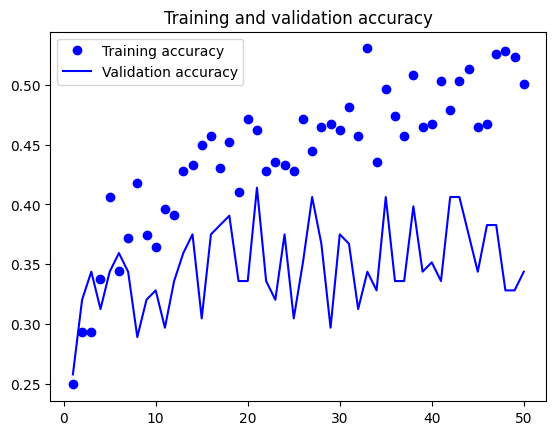

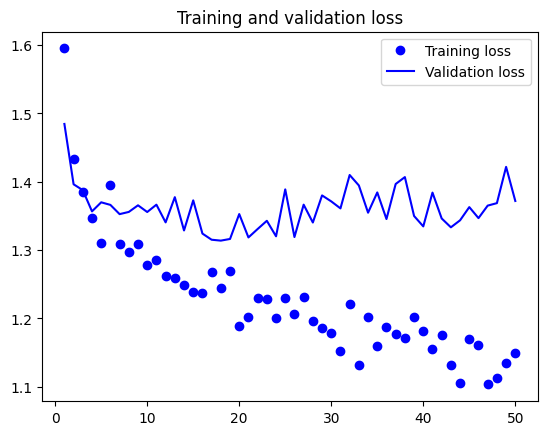

In [94]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### InceptionResNetV2

In [80]:
from keras.applications import InceptionResNetV2

In [81]:
resnet_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

219055592/219055592 [==============================] - 9s 0us/step


In [84]:
from keras.layers import GlobalAveragePooling2D

In [83]:

# Freeze the layers
for layer in resnet_v2.layers:
    layer.trainable = False

In [100]:
x = resnet_v2.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=resnet_v2.input, outputs=predictions)

In [101]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [102]:
# Define the optimizer and compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

In [103]:
# # Fit the model
# history = model.fit(
#     training_set,
#     steps_per_epoch=409//32,
#     epochs=50,
#     validation_data=valid_set,
#     validation_steps=128//32,
# )


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_with_inceptionResnet.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_set,
    steps_per_epoch=409//32,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks,
    validation_steps=128//32)

Epoch 1/50
12/12 [==============================] - 12s 573ms/step - loss: 1.9574 - accuracy: 0.3448 - val_loss: 1.8026 - val_accuracy: 0.3359
Epoch 2/50
12/12 [==============================] - 5s 375ms/step - loss: 1.5816 - accuracy: 0.2865 - val_loss: 1.4863 - val_accuracy: 0.3359
Epoch 3/50
12/12 [==============================] - 4s 363ms/step - loss: 1.4831 - accuracy: 0.2679 - val_loss: 1.4204 - val_accuracy: 0.2969
Epoch 4/50
12/12 [==============================] - 4s 361ms/step - loss: 1.4554 - accuracy: 0.2838 - val_loss: 1.4075 - val_accuracy: 0.3203
Epoch 5/50
12/12 [==============================] - 5s 379ms/step - loss: 1.4844 - accuracy: 0.3024 - val_loss: 1.4073 - val_accuracy: 0.3359
Epoch 6/50
12/12 [==============================] - 3s 275ms/step - loss: 1.4212 - accuracy: 0.2944 - val_loss: 1.4100 - val_accuracy: 0.3516
Epoch 7/50
12/12 [==============================] - 4s 376ms/step - loss: 1.4222 - accuracy: 0.3077 - val_loss: 1.3965 - val_accuracy: 0.3125
Epoch

In [98]:
test_model = keras.models.load_model(
    "./models/convnet_with_inceptionResnet.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2/2 [==============================] - 3s 106ms/step - loss: 1.3910 - accuracy: 0.3333
Test accuracy: 0.333


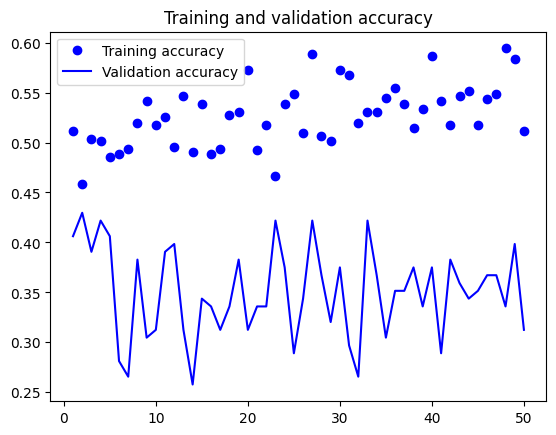

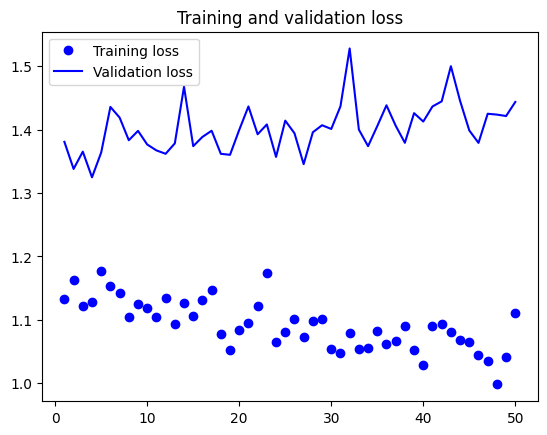

In [99]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()